In [83]:
from math import pi, sin, cos

import numpy as np
import torch
from scipy.optimize import minimize

import pyro
import pyro.contrib.gp as gp
torch.set_default_tensor_type(torch.DoubleTensor)

from matplotlib import pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.family'] = 'serif' # Setting font for plots


#### Setting Variables

In [84]:
######################### CHANGE DATA NOISE VARIANCE AND OFFSET HERE ###########################################
high_noise = 1.5                        # <--
low_noise = 0.1                         # <--
high_offset = 1.5                       # <--
low_offset = 0.05                       # <--

######################### CHOOSE NOISE VARIANCE AND OFFSET VALUES FOR INITIAL SAMPLES ##########################
ini_noise = high_noise                  # <--
ini_offset = 0                          # <--

######################### CHOOSE DATA FIDELITY: CHOOSE ONE ####################################################
fidelity = 1 # high noise               # <--
#fidelity = 2 # low noise               # <--
#fidelity = 3 # high offset             # <--
#fidelity = 4 # low offset              # <--

######################### CHOOSE NUMBER OF INITIAL X SAMPLES AND RANDOM SEED ###################################
num_ini_samples = 5                     # <--
seed = 7                                # <--

######################### CHOOSE RESULUTION OF X FOR EVALUATION OF SURROGATE GPR AND PLOTTING ##################
X_res = torch.linspace(-1.5, 1.5, 200)  # <--

######################### CHOOSE VARIANCE AND LENGTHSCALE FOR KERNEL ###########################################
var_kernel = torch.tensor(10)           # <--
length_kernel = torch.tensor(0.5)       # <--

######################### CHOOSE NOISE FOR GPR MODEL ###########################################################
gpr_noise = torch.tensor(high_noise)    # <--



#### Definition of Objective Function

In [85]:
def objective(x, noise=0.0, offset = 0.0):
    noise = np.random.normal(0, noise) + offset
    return ((x - 0.5)*x**3 + torch.sin(6*x) ) + noise

#### Initial sampling of the objective function

In [86]:
# Initial sampling of x in the selected domain
np.random.seed(seed)
X_ini,_ = torch.sort(torch.tensor(np.random.uniform(-1.5, 1.5, num_ini_samples))) 

# Sample the objective function with the initial x samples
y = torch.tensor([objective(x, noise=ini_noise, offset=ini_offset) for x in X_ini])

#### Plotting the initial samples and the objective function

In [87]:
# Function to plot objective function without disturbing the np.random.normal() - to ensure reproducibility
def plot_obj_func(x):
    return ((x - 0.5)*x**3 + torch.sin(6*x) )

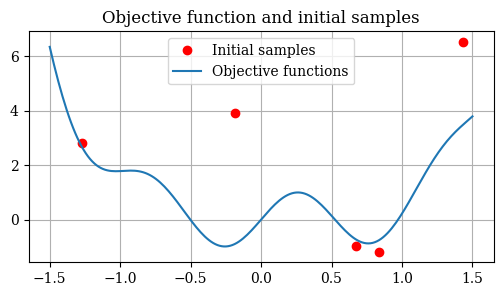

In [88]:
plt.figure(figsize=(6, 3))
plt.plot(X_ini, y, 'ro', label='Initial samples') # Plot the initial samples
plt.plot(X_res, plot_obj_func(X_res), label='Objective functions') # Plot the objective function without noise or offset
plt.title('Objective function and initial samples')
plt.legend()
plt.show()

### Plotting Objective Function and Global Minimum at x* 

In [89]:
def plot_obj():
    plt.figure(figsize=(10, 5))
    linewidth = 4
    
    plt.rc('axes', facecolor='#FFFFFF', edgecolor='#000000',
       axisbelow=True, grid=True)
    plt.plot(X_res, objective(X_res, noise=0, offset=0), lw =linewidth, label='Objective function') # Plot the objective function without noise or offset
    _, index = objective(X_res, noise=0, offset=0).min(dim=0)
    plt.plot( X_res[index], objective(X_res[index], noise=0, offset=0), 'C9^', markersize=25, label='Global minima') # Plot the global minima
    
    fontsize = 20
    plt.xlim([-1.52, 1.52])
    plt.ylim([-1.5, 6.5])
    plt.yticks([0,2, 4, 6],[0, 2, 4, 6], fontsize=fontsize ) 
    plt.xticks([-1.5, -1, -0.5, 0, 0.5, 1, 1.5],[-1.5, -1, -0.5, 0, 0.5, 1, 1.5], fontsize=fontsize )

    plt.legend(loc=1, prop = {'size':20}, framealpha=0.7)
  
    plt.xlabel("X", fontsize=30)
    plt.ylabel("Y", fontsize=30)
    plt.tight_layout(rect=[0.02, 0.04, 1, 1])
    #plt.savefig('obj_function_true_min_final.pdf', format='pdf')

#plot_obj()

#### Definition of the Kernel

In [90]:
# Clearing parameters
pyro.clear_param_store()

kernel = gp.kernels.RBF(
    input_dim=1,variance=var_kernel, lengthscale=length_kernel
    )

#### Definition of Surrogate Function - GPR

In [91]:
gpr = gp.models.GPRegression(X_ini, y, kernel=kernel, noise=gpr_noise)

# Define optimizer and loss function
optim = torch.optim.Adam(gpr.parameters(), lr=0.005) 
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss 
losses = []

#### Acquisition Function

In [92]:
def lower_confidence_bound(x, kappa, gpr):
    mu, variance = gpr(x, full_cov=False, noiseless=False)
    sigma = variance.sqrt()
    return mu - kappa * sigma

#### Optimization of the acquisition function

In [93]:
def opt_acquisition(x, kappa, gpr):
    min_val, min_index = lower_confidence_bound(x, kappa, gpr).min(dim=0)
    next_x = x[min_index]
    return next_x, min_val, min_index

#### Sampling with the Chosen Data Fidelity

In [94]:
def MultiFidelity(fidelity, new_x):
    if fidelity == 1: # high noise 
        new_y = objective(new_x, noise=high_noise, offset=0)
    elif fidelity == 2: # low noise
        new_y = objective(new_x, noise=low_noise, offset=0)
    elif fidelity == 3: # high offset
        new_y = objective(new_x, noise=0, offset=high_offset)
    elif fidelity == 4: # low offset
        new_y = objective(new_x, noise=0, offset=low_offset)
    else: 
        print("error, no fidelity chosen")
    return new_y

#### Updating the GPR Model with Every New Data Point

In [95]:
def new_posterior(new_x, gpr, fidelity): 
    new_x = new_x.unsqueeze(0)
    X = torch.cat([gpr.X, new_x])

    new_y = MultiFidelity(fidelity, new_x=new_x)
    
    y = torch.cat([gpr.y, new_y])
    gpr.set_data(X, y)

    optim.zero_grad()
    loss = loss_fn(gpr.model, gpr.guide)
    loss.backward()
    tr_loss = loss.item() 
    optim.step()
    tr_loss /= len(X) 
    losses.append(tr_loss)


In [96]:
# must be positive to have a well defined kernel
gpr.kernel.variance.item()
gpr.kernel.lengthscale.item()
gpr.noise.item()

1.5

#### Kappa function - exploration vs exploitation

In [97]:
def deter_kappa(ini_kappa, i, dec_param):
    new_kappa = ini_kappa - i*dec_param
    return new_kappa

### Function to make nice plots

In [98]:
def plot_only_baye(ax1, gpr, next_x, min_val, X_plot_res, kappa, i):
    linewidth = 4
    fontsize = 30

    with torch.no_grad():
        mu, variance = gpr(X_plot_res, full_cov=False, noiseless=False)
        sigma = variance.sqrt()
        ax1.plot(X_plot_res.numpy(), mu.numpy(), color="C0", lw = linewidth, label ='Predicted mean') # Plot the mean of the surrogate model
        ax1.fill_between(X_plot_res.numpy(), mu.numpy() - kappa * sigma.numpy(), 
                         mu.numpy() + kappa * sigma.numpy(), color="C0", alpha=0.3)

        ax1.plot(gpr.X.numpy(), gpr.y.numpy(), 'ro', markersize = 15, label='Samples') # Plot the samples
        ax1.plot(X_plot_res, plot_obj_func(X_plot_res), 'k', lw=linewidth, label='Objective function') # Plot the objective function 

    with torch.no_grad(): # Plotting LCB and next x to sample
        ax1.plot(X_plot_res.numpy(), lower_confidence_bound(X_plot_res, kappa, gpr).numpy(), "C9--", lw = linewidth, label="LCB")
        ax1.plot(next_x.numpy(), min_val.numpy(), "C9^", markersize=25, lw=0, label = 'Next x')

    ax1.set_title(f'Finding sample {i+1}', fontsize = fontsize)
    ax1.set_xlim([-1.52, 1.52])
    ax1.set_ylim([-16, 10]) # 15
    ax1.set_yticks([-10,0,10],['-10', '0', '10'], fontsize=fontsize ) 
    ax1.set_xticks([-1.5, -1, -0.5, 0, 0.5, 1, 1.5],[-1.5, -1, -0.5, 0, 0.5, 1, 1.5], fontsize=fontsize )

##### Values for Plotting

In [99]:
######################### VARIABLES FOR PLOTTING - DONT CHANGE ###############################
early_stop = 1 # initialising of int for early stopping
old_x = 0
j = 0 # for plotting in the correct subplot

######################### CHOOSE NUMBER OF ITERATIONS AND MARGIN FOR X #######################
iterations = 48                           # <--
margin = 0#.02                            # <--

######################### CHOOSE INITIAL KAPPA AND CHANGE DEC_PARAM ##########################
ini_kappa = 6.0                           # <--
dec_param = (ini_kappa-1)/iterations      # <--

######################### GRID ###############################################################
plt.rc('axes', facecolor='#FFFFFF', edgecolor='#000000',
       axisbelow=True, grid=True)

0.10416666666666667


## Bayesian optimization loop

tensor(-0.7462)
tensor(0.3844)
tensor(-1.5000)
tensor(0.6407)
tensor(0.6558)
tensor(0.6256)
tensor(0.8065)
tensor(0.5804)
tensor(0.8216)
tensor(0.7613)
tensor(0.7312)
tensor(0.7312)
tensor(0.6859)
tensor(0.7010)
tensor(0.7010)
tensor(0.7010)
tensor(0.7010)
tensor(0.7161)
tensor(0.7312)
tensor(0.7312)
tensor(0.7764)
tensor(0.7764)
tensor(0.8367)
tensor(0.8216)
tensor(0.7764)
tensor(0.7613)
tensor(0.7462)
tensor(0.7613)
tensor(0.7613)
tensor(0.7764)
tensor(0.7462)
tensor(0.7462)
tensor(0.7462)
tensor(0.7613)
tensor(0.7613)
tensor(0.7462)
tensor(0.7462)
tensor(0.7462)
tensor(0.7462)
tensor(0.7462)
Noise level: 1.5
Offset level: 0
Margin for early stopping: 0
Number of iterations to achieve convergence: 39
Final value of kappa, when convergence was reached: 2.0416666666666665
Final value of x^* = 0.75
Estimated minimum value according to GPR mean: -1.1640127439811705


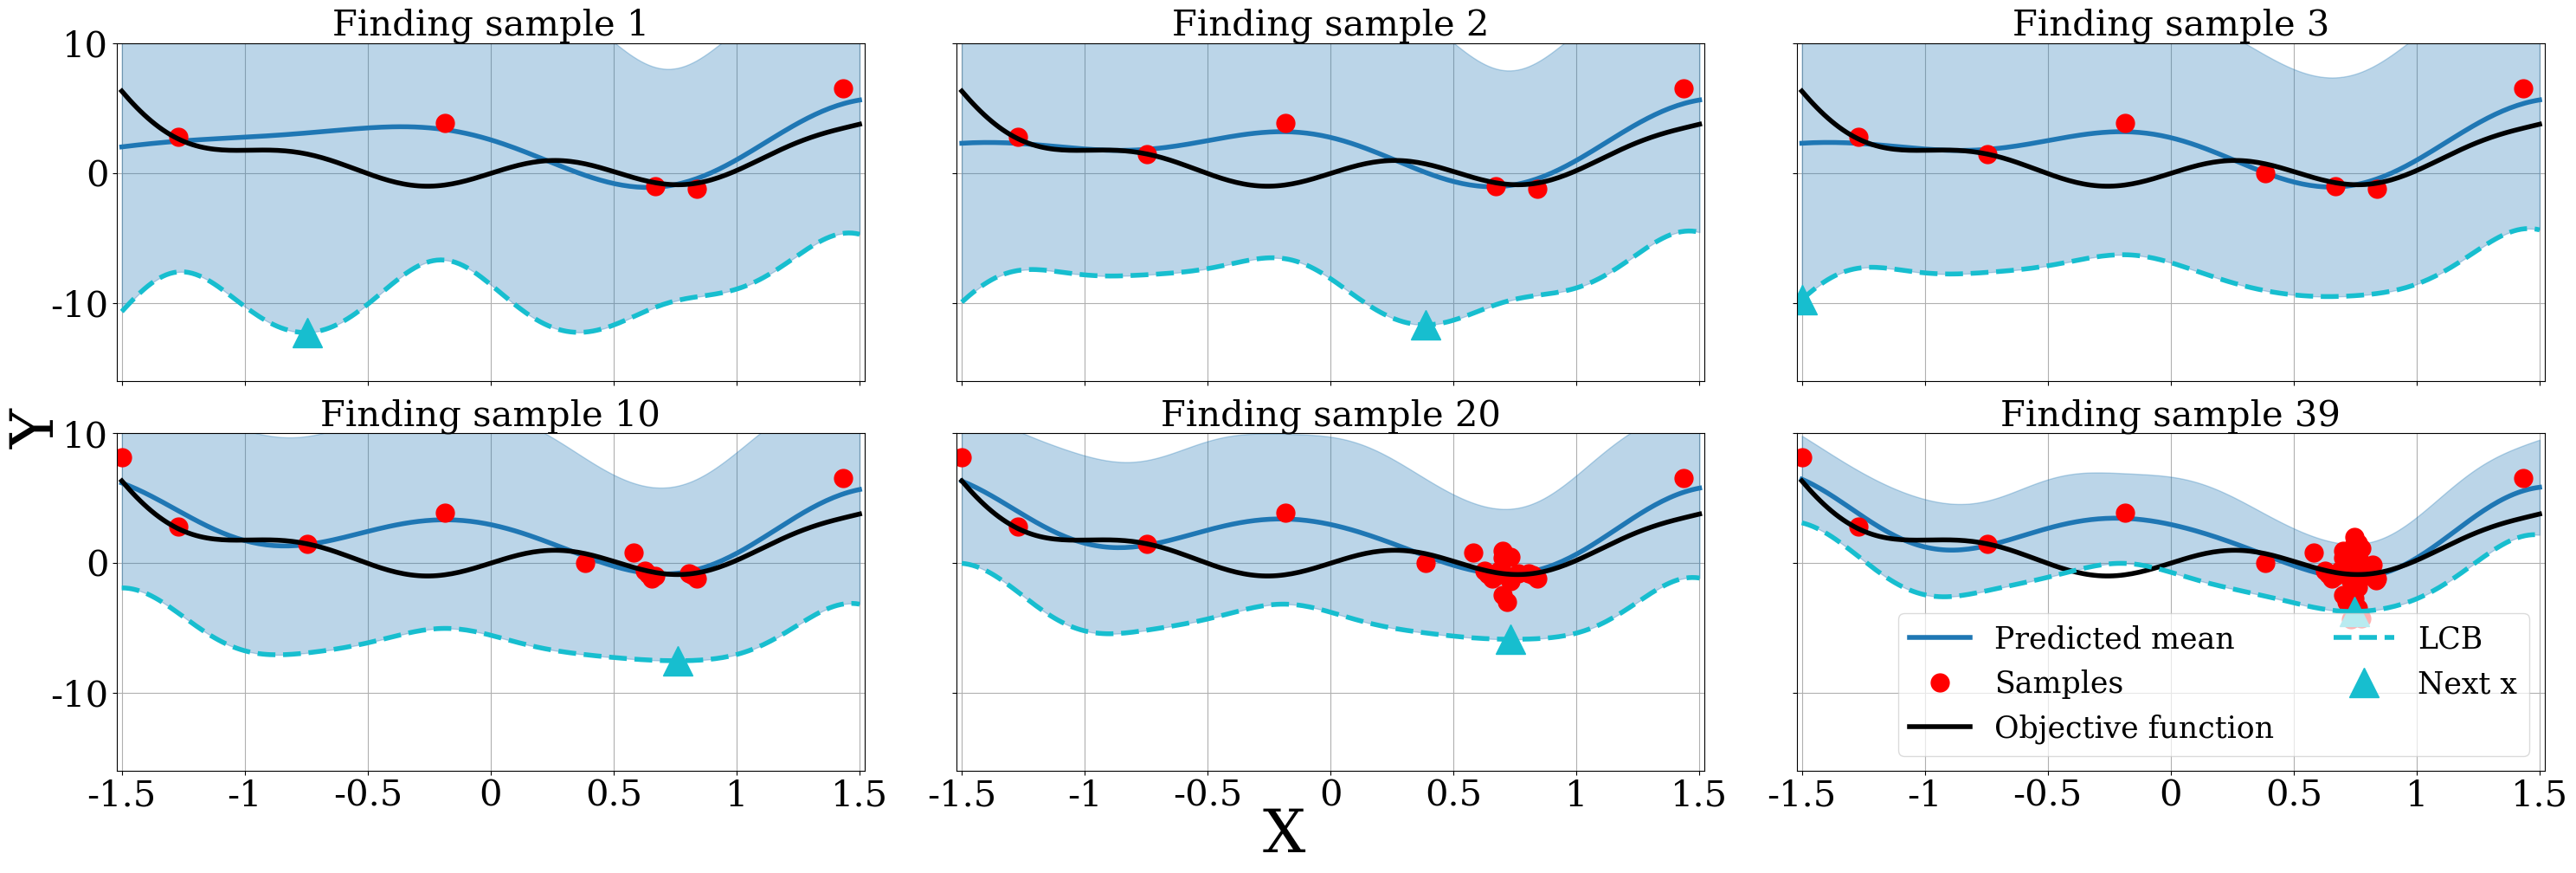

In [100]:
gp.util.train(gpr, optim, loss_fn=loss_fn, num_steps=1)

# To plot all optimization steps
#fig, axes = plt.subplots(ncols=3, nrows = int(iterations/3 - 3), figsize = (30,25),sharex = True,sharey = True) 
#for i, ax in enumerate(fig.get_axes()):

fig, axes = plt.subplots(ncols=3, nrows = 2, figsize = (30,10),sharex = True,sharey = True)  #nrows=3, (30,15)
axs = fig.get_axes()

for i in range(iterations):
    if i >= iterations:
        break
    
    kappa = deter_kappa(ini_kappa, i, dec_param) # Decrease kappa
    next_x, min_val, min_index = opt_acquisition(X_res, kappa, gpr) # Find next x to sample and the minimum value of the acquisition function
    print(next_x)

    if abs(next_x - old_x) <= margin: # Early stopping mechanism
        early_stop += 1
        if early_stop == 5:
            print(f"Noise level: {ini_noise}")
            print(f"Offset level: {ini_offset}")
            print(f"Margin for early stopping: {margin}")
            print(f"Number of iterations to achieve convergence: {i}") 
            print(f"Final value of kappa, when convergence was reached: {kappa+dec_param}")
            print(f"Final value of x^* = {next_x.numpy():.2f}")
            with torch.no_grad():
                mu,_ = gpr(X_res, full_cov=False, noiseless=False)
                print(f"Estimated minimum value according to GPR mean: {mu[min_index]}")
            break
    elif next_x != old_x:
        early_stop = 1
    else:
        "Error with early stopping"
    
    # Plotting only certain steps in the optimization
    if i == 0 or i == 1 or i == 2 or i == 9  or i == 19  or i == 38:
        plot_only_baye(axs[j], gpr, next_x, min_val, X_res, kappa, i)
        j += 1
    new_posterior(next_x, gpr, fidelity)
    old_x = next_x

fig.text(0.5, 0.03, 'X', ha='center', va='center', fontsize = 50)
fig.text(0.02, 0.5, 'Y', ha='center', va='center', rotation='vertical', fontsize = 50)
axes[1,-1].legend(loc=4, prop={'size': 25}, ncol = 2, framealpha=0.7)
plt.tight_layout(rect=[0.02, 0.04, 1, 1])
#plt.savefig('high_noise_also_gpr.pdf', format='pdf')